In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import os
import xgboost as xgb
import lightgbm as lgb

import os
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_columns', 150)

In [2]:
POS_CASH_balance = pd.read_pickle('../home credit/POS_CASH_balance.pickle')
bureau_balance = pd.read_pickle('../home credit/bureau_balance.pickle')
application_train = pd.read_pickle('../home credit/application_train.pickle')
previous_application = pd.read_pickle('../home credit/previous_application.pickle')
installments_payments = pd.read_pickle('../home credit/installments_payments.pickle')
credit_card_balance = pd.read_pickle('../home credit/credit_card_balance.pickle')
application_test = pd.read_pickle('../home credit/application_test.pickle')
bureau = pd.read_pickle('../home credit/bureau.pickle')
description = pd.read_csv('../home credit/HomeCredit_columns_description.csv', index_col=0).iloc[:,0:5]
pd.options.display.max_colwidth = 20000
def search_description(column):
    return description.loc[description.Row == column][['Description','日本語訳']]

# EDA

In [3]:
def cat_eda(cat_feature):
    sns.countplot(cat_feature, hue='TARGET', data=application_train)
    plt.xticks(rotation=20)
    plt.show()
    group1 = application_train[['TARGET', cat_feature]].loc[application_train.TARGET == 1].groupby(cat_feature).count().reset_index()
    group0 = application_train[['TARGET', cat_feature]].loc[application_train.TARGET == 0].groupby(cat_feature).count().reset_index()
    group = pd.merge(group1, group0, on=cat_feature)
    group.columns = [cat_feature, 'TARGET_1', 'TARGET_0']
    group['TARGET_1_ratio'] = (group['TARGET_1'] / group['TARGET_0']) * 100
    group = group.sort_values(by='TARGET_1_ratio', ascending=False)
    sns.barplot(x=cat_feature, y='TARGET_1_ratio', data=group)
    plt.xticks(rotation=20)
    plt.show()

In [4]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,

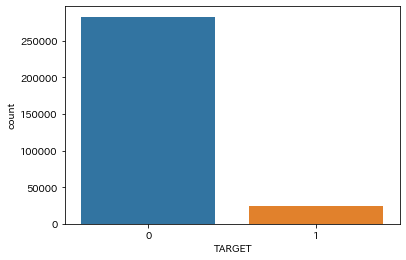

In [5]:
sns.countplot('TARGET', data=application_train)

# 契約のタイプ

In [6]:
pd.crosstab(application_train.TARGET, application_train.NAME_CONTRACT_TYPE, dropna=False, normalize='all')

NAME_CONTRACT_TYPE,Cash loans,Revolving loans
TARGET,,
0,0.829274,0.089997
1,0.075513,0.005216


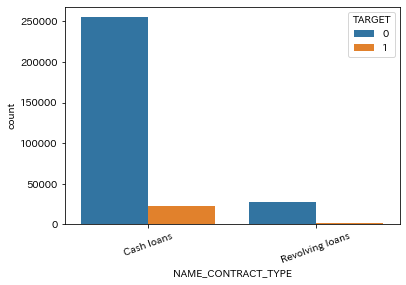

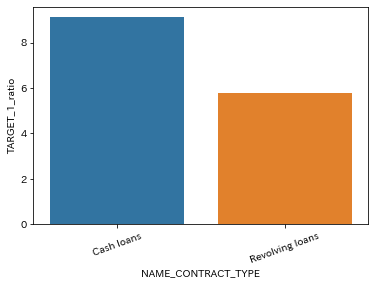

In [7]:
cat_eda('NAME_CONTRACT_TYPE')

# 性別

In [8]:
pd.crosstab(application_train.TARGET, application_train.CODE_GENDER, dropna=False, normalize='all')

CODE_GENDER,F,M,XNA
TARGET,,,
0,0.612264,0.306994,0.000013
1,0.046080,0.034649,0.000000


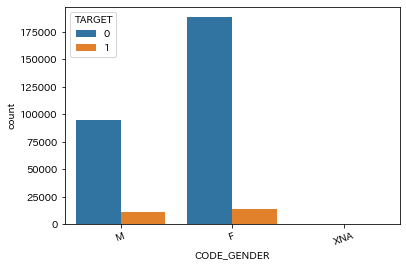

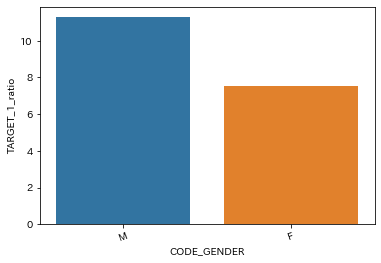

In [9]:
cat_eda('CODE_GENDER')

# 不動産の保持

In [10]:
print('There are {0} people with realty. {1}% of them repay loans.'.format(application_train[application_train.FLAG_OWN_REALTY == 'Y'].shape[0], np.round(application_train[application_train.FLAG_OWN_REALTY == 'Y'].TARGET.value_counts(normalize=True).values[1], 3) * 100))
print('There are {0} people with cars. {1}% of them repay loans.'.format(application_train[application_train.FLAG_OWN_CAR == 'Y'].shape[0], np.round(application_train[application_train.FLAG_OWN_CAR == 'Y'].TARGET.value_counts(normalize=True).values[1], 4) * 100))
print('Average age of the car is {:.2f} years.'.format(application_train.groupby(['FLAG_OWN_CAR'])['OWN_CAR_AGE'].mean().values[1]))

There are 213312 people with realty. 8.0% of them repay loans.
There are 104587 people with cars. 7.24% of them repay loans.
Average age of the car is 12.06 years.


In [11]:
pd.crosstab(application_train.CNT_CHILDREN, application_train.NAME_FAMILY_STATUS, dropna=False)

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
CNT_CHILDREN,,,,,,
0,20947,126575,14132,38810,2,14905
1,6588,43696,4389,5578,0,868
2,1936,22496,1111,958,0,248
3,262,3190,122,85,0,58
4,33,370,12,9,0,5
5,5,74,2,1,0,2
6,2,17,1,0,0,1
7,1,5,0,0,0,1
8,0,2,0,0,0,0


In [12]:
pd.crosstab(application_train.TARGET, application_train.NAME_FAMILY_STATUS, dropna=False, normalize='all')

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
TARGET,,,,,,
0,0.087197,0.590489,0.059022,0.133286,0.000007,0.049270
1,0.009629,0.048291,0.005268,0.014494,0.000000,0.003047


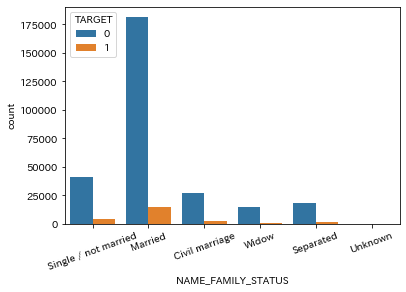

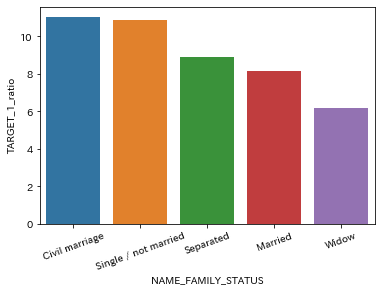

In [13]:
cat_eda('NAME_FAMILY_STATUS')

# 子供の人数

In [14]:
pd.crosstab(application_train.CNT_CHILDREN, application_train.NAME_FAMILY_STATUS, dropna=False)

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
CNT_CHILDREN,,,,,,
0,20947,126575,14132,38810,2,14905
1,6588,43696,4389,5578,0,868
2,1936,22496,1111,958,0,248
3,262,3190,122,85,0,58
4,33,370,12,9,0,5
5,5,74,2,1,0,2
6,2,17,1,0,0,1
7,1,5,0,0,0,1
8,0,2,0,0,0,0


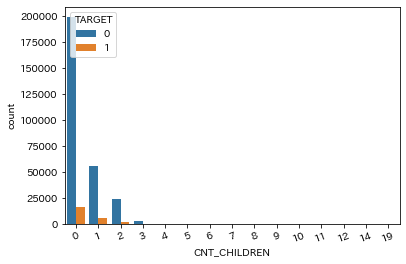

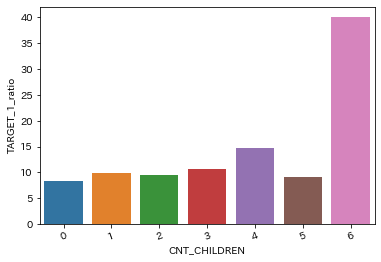

In [15]:
cat_eda('CNT_CHILDREN')

### 気になったので調べてみる

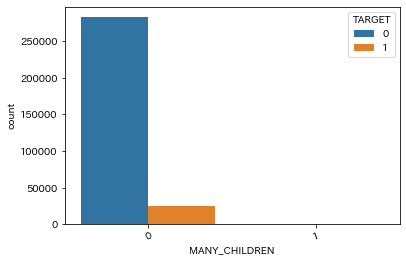

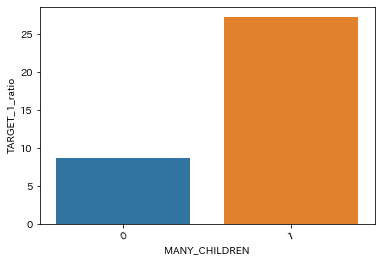

In [16]:
application_train['MANY_CHILDREN'] = (application_train["CNT_CHILDREN"] > 5) * 1
cat_eda('MANY_CHILDREN')

### 子供の人数が多いと明らかに債務不履行リスクが高まる

# 家族の人数

In [17]:
pd.crosstab(application_train.CNT_CHILDREN, application_train.CNT_FAM_MEMBERS, dropna=False)

CNT_FAM_MEMBERS,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,20.0
CNT_CHILDREN,,,,,,,,,,,,,,,,,
0,67847,147522,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,10835,50284,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2317,24432,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,265,3452,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,26,403,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,5,79,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,2,19,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,6,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0


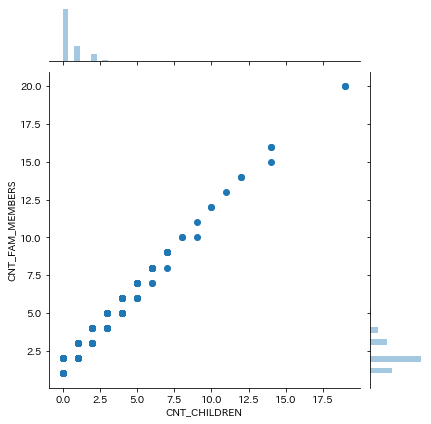

In [18]:
application_train['CNT_CHILDREN'].corr(application_train['CNT_FAM_MEMBERS'])
sns.jointplot('CNT_CHILDREN', 'CNT_FAM_MEMBERS', data=application_train)
#ほとんど比例関係

# 保証人

In [19]:
application_train['NAME_TYPE_SUITE'].value_counts(dropna=False)

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
NaN                  1292
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

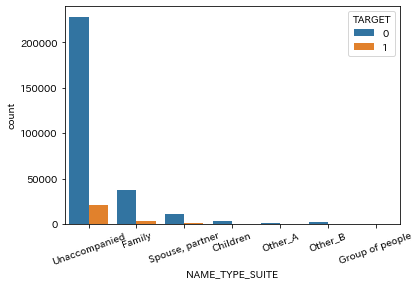

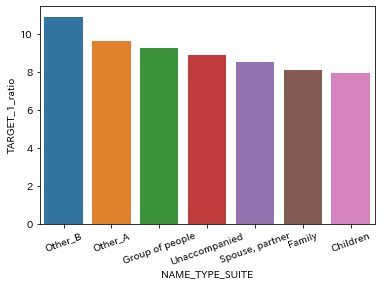

In [20]:
cat_eda('NAME_TYPE_SUITE')

# 収入のタイプ

In [21]:
application_train.groupby(['NAME_INCOME_TYPE']).agg({'AMT_INCOME_TOTAL': ['mean', 'median', 'count']})

AMT_INCOME_TOTAL                  
                                 mean    median   count
NAME_INCOME_TYPE                                       
Businessman             652500.000000  495000.0      10
Commercial associate    202955.328125  180000.0   71617
Maternity leave         140400.000000   90000.0       5
Pensioner               136401.296875  117000.0   55362
State servant           179737.968750  157500.0   21703
Student                 170500.000000  157500.0      18
Unemployed              110536.367188   78750.0      22
Working                 163169.890625  135000.0  158774

In [22]:
application_train[application_train['NAME_INCOME_TYPE'] == 'Maternity leave']['CODE_GENDER'].value_counts()

F    4
M    1
Name: CODE_GENDER, dtype: int64

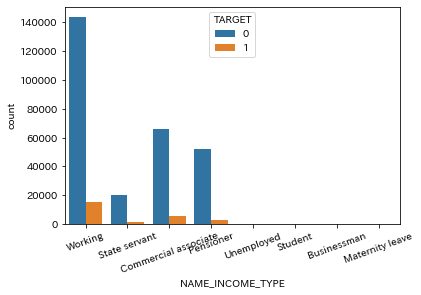

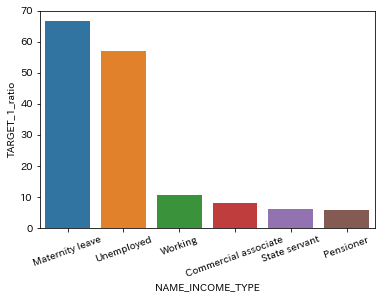

In [23]:
cat_eda('NAME_INCOME_TYPE')

# AMT_GOODS_PRICE

In [24]:
search_description('AMT_GOODS_PRICE')

,Description,日本語訳
13,For consumer loans it is the price of the goods for which the loan is given,消費者ローンのために、それは、ローンが与えられるため、商品の価格です
183,Goods price of good that client asked for (if applicable) on the previous application,以前のアプリケーション上のクライアントがを求めていることは良いの商品代金（該当する場合）


In [25]:
search_description('AMT_CREDIT')

,Description,日本語訳
11,Credit amount of the loan,ローンの与信額
181,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT",以前のアプリケーション上で、最終的なクレジット。 AMT_APPLICATIONは、クライアントが最初に適用される量であるが、私たちの承認プロセスの間に、彼は別の金額を受け取っている可能性があることのようにAMT_APPLICATIONからこの異なっ - AMT_CREDIT


In [26]:
print('{0} zero values.'.format(application_train[application_train['AMT_GOODS_PRICE'].isnull()].shape[0]))

278 zero values.


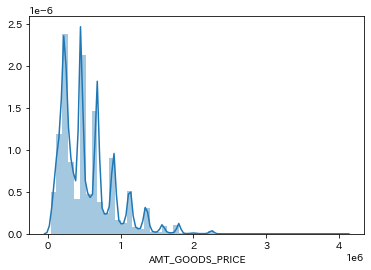

In [27]:
sns.distplot(application_train['AMT_GOODS_PRICE'])

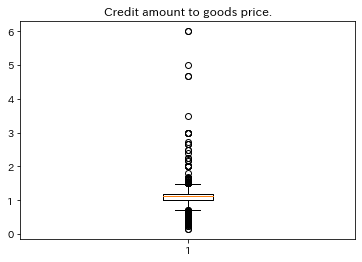

In [28]:
non_zero_good_price = application_train[application_train['AMT_GOODS_PRICE'].isnull() == False]
credit_to_good_price = non_zero_good_price['AMT_CREDIT'] / non_zero_good_price['AMT_GOODS_PRICE']
plt.boxplot(credit_to_good_price);
plt.title('Credit amount to goods price.');
# goods_priceと与信額の比率を見ています。ほとんどは同じような額を示していますが、外れ値もあります。

# NAME_HOUSING_TYPE

Text(0.5, 1.0, 'Counts of housing type')

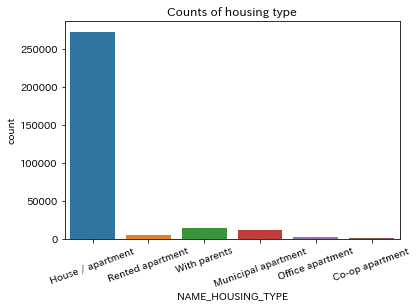

In [29]:
sns.countplot(application_train['NAME_HOUSING_TYPE']);
plt.xticks(rotation=20);
plt.title('Counts of housing type')

In [30]:
application_train['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'Rented apartment', 'With parents',
       'Municipal apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

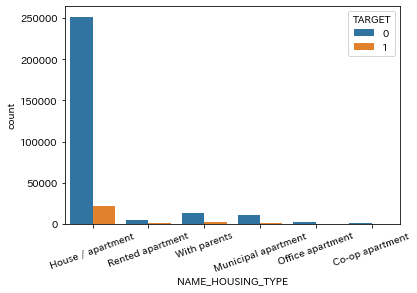

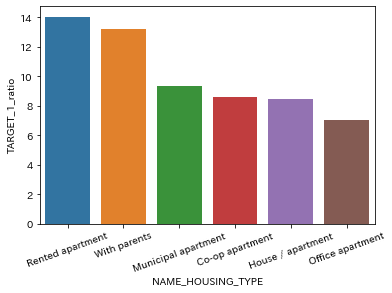

In [31]:
cat_eda('NAME_HOUSING_TYPE')

# どのように契約したのか

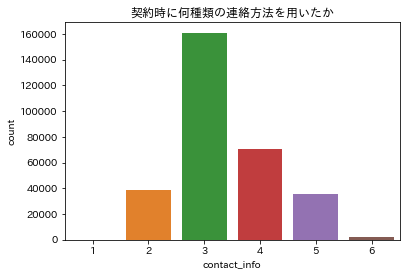

In [32]:
application_train['contact_info'] = application_train['FLAG_MOBIL'] + application_train['FLAG_EMP_PHONE'] + application_train['FLAG_WORK_PHONE'] + application_train['FLAG_CONT_MOBILE'] + application_train['FLAG_PHONE'] + application_train['FLAG_EMAIL']
sns.countplot(application_train['contact_info']);
plt.title('契約時に何種類の連絡方法を用いたか');
# 意味あるのか？

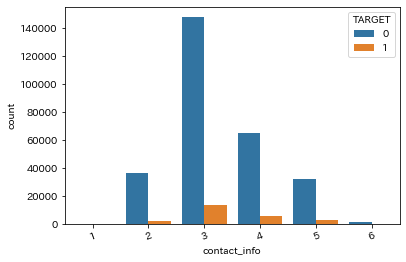

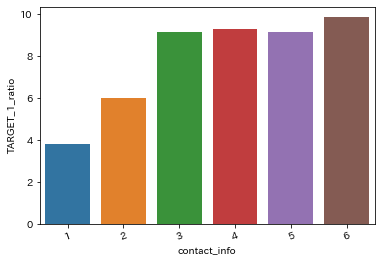

In [33]:
cat_eda('contact_info')

# ソーシャルサークル

In [34]:
application_train.loc[application_train['OBS_30_CNT_SOCIAL_CIRCLE'] > 1, 'OBS_30_CNT_SOCIAL_CIRCLE'] = '1+'
application_train.loc[application_train['DEF_30_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_30_CNT_SOCIAL_CIRCLE'] = '1+'
application_train.loc[application_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 1, 'OBS_60_CNT_SOCIAL_CIRCLE'] = '1+'
application_train.loc[application_train['DEF_60_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_60_CNT_SOCIAL_CIRCLE'] = '1+'

In [35]:
search_description('DEF_30_CNT_SOCIAL_CIRCLE')

,Description,日本語訳
95,How many observation of client's social surroundings defaulted on 30 DPD (days past due),30 DPD（延滞日数）にどのように多くのクライアントの社会的な環境の観測をデフォルトに設定


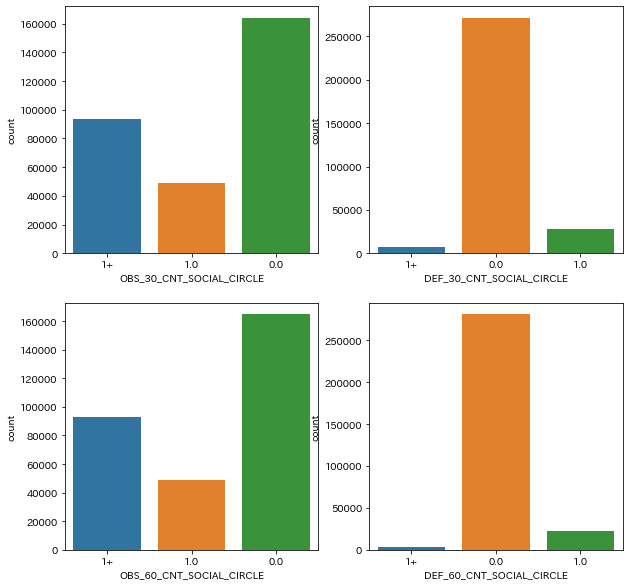

In [36]:
fig, ax = plt.subplots(2,2,figsize = (10,10))

sns.countplot(application_train['OBS_30_CNT_SOCIAL_CIRCLE'], ax=ax[0,0]);
sns.countplot(application_train['DEF_30_CNT_SOCIAL_CIRCLE'], ax=ax[0,1]);
sns.countplot(application_train['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax[1,0]);
sns.countplot(application_train['DEF_60_CNT_SOCIAL_CIRCLE'], ax=ax[1,1]);

#### 正直この変数の内容が意味わからなくて何とも言えない

# 数値変数

# 年収

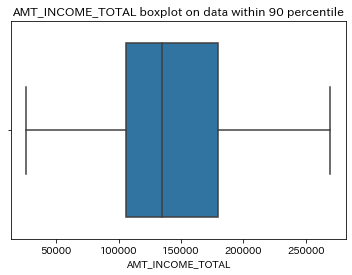

In [37]:
sns.boxplot(application_train[application_train['AMT_INCOME_TOTAL'] < np.percentile(application_train['AMT_INCOME_TOTAL'], 90)]['AMT_INCOME_TOTAL']);
plt.title('AMT_INCOME_TOTAL boxplot on data within 90 percentile');

In [38]:
application_train.groupby('TARGET').agg({'AMT_INCOME_TOTAL': ['mean', 'median', 'count']})

AMT_INCOME_TOTAL                  
                   mean    median   count
TARGET                                   
0         169077.718750  148500.0  282686
1         165611.765625  135000.0   24825

中央値が148500ドル(多分ドル)、日本円で1600万円

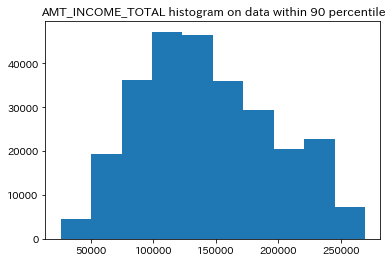

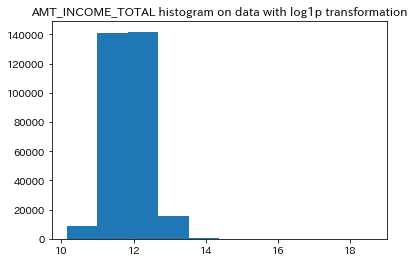

In [39]:
plt.hist(application_train[application_train['AMT_INCOME_TOTAL'] < np.percentile(application_train['AMT_INCOME_TOTAL'], 90)]['AMT_INCOME_TOTAL']);
plt.title('AMT_INCOME_TOTAL histogram on data within 90 percentile');
plt.show()
plt.hist(np.log1p(application_train['AMT_INCOME_TOTAL']));
plt.title('AMT_INCOME_TOTAL histogram on data with log1p transformation');

以下のことがわかる
1. 大きな外れ値がある
2. 90％の信頼区間で見てみれば、ほとんど正規分布
3. 対数変換も役に立つ（微妙に見えるが、、、）

# 年齢

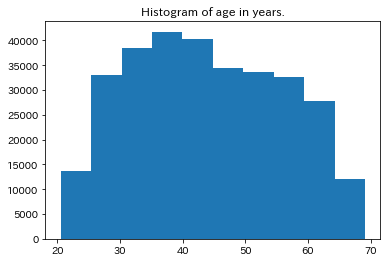

In [40]:
application_train['age'] = application_train['DAYS_BIRTH'] / -365
plt.hist(application_train['age']);
plt.title('Histogram of age in years.');

# 現在の職場で何年働いているか

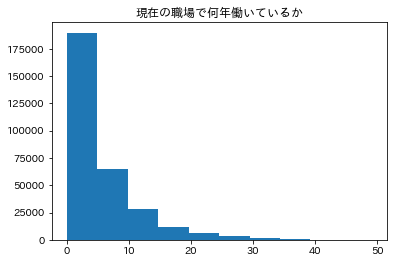

In [41]:
application_train.loc[application_train['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = 0
application_train['years_employed'] = application_train['DAYS_EMPLOYED'] / -365
plt.hist(application_train['years_employed']);
plt.title('現在の職場で何年働いているか');

In [42]:
application_train.groupby(['NAME_INCOME_TYPE']).agg({'years_employed': ['mean', 'median', 'count', 'max'], 'age': ['median']})
# 職業ごとに勤続年数も違いがあるよ

years_employed                                     age
                               mean    median   count        max     median
NAME_INCOME_TYPE                                                           
Businessman                7.874795  6.280822      10  14.917808  47.498630
Commercial associate       5.833627  4.147945   71617  48.071233  39.780822
Maternity leave            7.224110  8.273973       5  10.306849  39.350685
Pensioner                  0.002448 -0.000000   55362  35.246575  60.413699
State servant              9.454441  7.205479   21703  48.172603  40.693151
Student                    6.835160  5.069863      18  21.931507  36.663014
Unemployed                 0.000000 -0.000000      22  -0.000000  45.860274
Working                    6.446909  4.427397  158774  49.073973  39.876712

In [43]:
application_train.groupby(['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE']).agg({'AMT_INCOME_TOTAL': ['mean', 'median', 'count', 'max']})

AMT_INCOME_TOTAL  \
                                                               mean   
NAME_EDUCATION_TYPE           NAME_INCOME_TYPE                        
Academic degree               Commercial associate    274688.375000   
                              Pensioner               203919.234375   
                              State servant           258847.828125   
                              Working                 226312.500000   
Higher education              Businessman             652500.000000   
                              Commercial associate    242284.000000   
                              Maternity leave         195000.000000   
                              Pensioner               171455.109375   
                              State servant           207116.156250   
                              Student                 231000.000000   
                              Unemployed              189000.000000   
                              Working                 194013.109375   
Incomplete higher             Commercial associate    206232.296875   
                              Pensioner               149437.156250   
                              State servant           173589.984375   
                              Student                 157500.000000   
                              Unemployed              126000.000000   
                              Working                 170659.484375   
Lower secondary               Commercial associate    168173.625000   
                              Pensioner               106468.007812   
                              State servant           143250.000000   
                              Working                 140070.656250   
Secondary / secondary special Commercial associate    181368.703125   
                              Maternity leave          58500.000000   
                              Pensioner               130863.484375   
                              State servant           159979.343750   
                              Student                 138681.812500   
                              Unemployed               70753.843750   
                              Working                 154261.796875   

                                                                       \
                                                       median   count   
NAME_EDUCATION_TYPE           NAME_INCOME_TYPE                          
Academic degree               Commercial associate  247500.00      43   
                              Pensioner             155700.00      26   
                              State servant         225000.00      23   
                              Working               202500.00      72   
Higher education              Businessman           495000.00      10   
                              Commercial associate  202500.00   24025   
                              Maternity leave       135000.00       3   
                              Pensioner             148500.00    8188   
                              State servant         180000.00    8863   
                              Student               175500.00       6   
                              Unemployed            180000.00       6   
                              Working               174134.25   33762   
Incomplete higher             Commercial associate  180000.00    3400   
                              Pensioner             135000.00     518   
                              State servant         157500.00     770   
                              Student               157500.00       1   
                              Unemployed             63000.00       3   
                              Working               157500.00    5585   
Lower secondary               Commercial associate  144000.00     460   
                              Pensioner              90000.00    1529   
                              State servant         119250.00     102   
                          

We can see that most of the loans are taken by working people with secondary education.だそうです

# Transforming and merging data

対数変換と欠損補完

In [44]:
application_train['AMT_INCOME_TOTAL'] = np.log1p(application_train['AMT_INCOME_TOTAL'])
application_train['AMT_CREDIT'] = np.log1p(application_train['AMT_CREDIT'])
application_train['OWN_CAR_AGE'] = application_train['OWN_CAR_AGE'].fillna(0)

In [45]:
search_description('AMT_ANNUITY')

,Description,日本語訳
12,Loan annuity,ローン年金
141,Annuity of the Credit Bureau credit,クレジットビューローの信用の年金
179,Annuity of previous application,以前のアプリケーションの年金


In [46]:
application_train['app AMT_CREDIT / AMT_ANNUITY'] = application_train['AMT_CREDIT'] / application_train['AMT_ANNUITY']
# 与信額と年金(支払額？)の比率
# application_train['app EXT_SOURCE mean'] = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
# 外部データの平均値をとったもの
application_train['app EXT_SOURCE_1 / DAYS_BIRTH'] = application_train['EXT_SOURCE_1'] / application_train['DAYS_BIRTH']
# 外部データ1を年齢で割ったもの
application_train['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = application_train['AMT_INCOME_TOTAL'] / 12. - application_train['AMT_ANNUITY']
# 毎月の手取り
application_train['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = application_train['AMT_INCOME_TOTAL'] / application_train['AMT_ANNUITY']
# 収入と支払い年金額の比率
application_train['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = application_train['AMT_INCOME_TOTAL'] - application_train['AMT_GOODS_PRICE']
# 収入　ー　ローンの額

testにも同じ操作

In [47]:
application_test.loc[application_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 1, 'OBS_30_CNT_SOCIAL_CIRCLE'] = '1+'
application_test.loc[application_test['DEF_30_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_30_CNT_SOCIAL_CIRCLE'] = '1+'
application_test.loc[application_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 1, 'OBS_60_CNT_SOCIAL_CIRCLE'] = '1+'
application_test.loc[application_test['DEF_60_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_60_CNT_SOCIAL_CIRCLE'] = '1+'
np.log1p(application_test['AMT_INCOME_TOTAL'])
np.log1p(application_test['AMT_CREDIT'])
application_test['age'] = application_test['DAYS_BIRTH'] / -365
application_test.loc[application_test['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = 0
application_test['years_employed'] = application_test['DAYS_EMPLOYED'] / -365
application_test['AMT_INCOME_TOTAL'] = np.log1p(application_test['AMT_INCOME_TOTAL'])
application_test['AMT_CREDIT'] = np.log1p(application_test['AMT_CREDIT'])
application_test['OWN_CAR_AGE'] = application_test['OWN_CAR_AGE'].fillna(0)
application_test['app AMT_CREDIT / AMT_ANNUITY'] = application_test['AMT_CREDIT'] / application_test['AMT_ANNUITY']
# application_test['app EXT_SOURCE mean'] = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
application_test['app EXT_SOURCE_1 / DAYS_BIRTH'] = application_test['EXT_SOURCE_1'] / application_test['DAYS_BIRTH']
application_test['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = application_test['AMT_INCOME_TOTAL'] / 12. - application_test['AMT_ANNUITY']
application_test['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = application_test['AMT_INCOME_TOTAL'] / application_test['AMT_ANNUITY']
application_test['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = application_test['AMT_INCOME_TOTAL'] - application_test['AMT_GOODS_PRICE']

ラベルエンコーディング

In [48]:
for col in ['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
           'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
            'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START']:
    unique_values = list(set(list(application_train[col].astype(str).unique()) + list(application_test[col].astype(str).unique())))
    le.fit(unique_values)
    application_train[col] = le.transform(application_train[col].astype(str))
    application_test[col] = le.transform(application_test[col].astype(str))

## モデリング

In [49]:
train = application_train
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,MANY_CHILDREN,contact_info,age,years_employed,app AMT_CREDIT / AMT_ANNUITY,app EXT_SOURCE_1 / DAYS_BIRTH,app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY,app AMT_INCOME_TOTAL / AMT_ANNUITY,app AMT_INCOME_TOTAL - AMT_GOODS_PRICE
0,100002,1,0,1,0,1,0,12.218500,12.915582,24700.5,351000.0,6,7,4,3,1,0.018799,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.000000,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,3,0,0.014900,5,0,1,1,1,1,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,4,25.920548,1.745205,0.000523,-0.000009,-24699.482422,0.000495,-3.509878e+05
1,100003,0,0,0,0,0,0,12.506181,14.072865,35698.5,1129500.0,1,4,1,1,1,0.003542,-16765,-1188,-1186.0,-291,0.0,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.000000,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,3,0,0.071411,0,0,2,0,2,0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,45.931507,3.254795,0.000394,-0.000019,-35697.457031,0.000350,-1.129488e+06
2,100004,0,1,1,1,1,0,11.119898,11.813038,6750.0,135000.0,6,7,4,3,1,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0

In [50]:
test = application_test
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,age,years_employed,app AMT_CREDIT / AMT_ANNUITY,app EXT_SOURCE_1 / DAYS_BIRTH,app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY,app AMT_INCOME_TOTAL / AMT_ANNUITY,app AMT_INCOME_TOTAL - AMT_GOODS_PRICE
0,100001,0,0,0,1,0,11.813038,13.251286,20560.5,450000.0,6,7,1,1,1,0.018845,-19241,-2329,-5168.0,-812,0.0,1,1,0,1,0,1,18,2.0,2,2,5,18,0,0,0,0,0,0,28,0.752441,0.789551,0.159546,0.065979,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125000,NaN,NaN,NaN,0.050507,NaN,NaN,0.067200,0.061188,0.973145,NaN,NaN,NaN,0.137939,0.125000,NaN,NaN,NaN,0.052612,NaN,NaN,0.066589,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125000,NaN,NaN,NaN,0.051392,NaN,NaN,0,0,0.039215,5,0,0,0,0,0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,52.715068,6.380822,0.000645,-0.000039,-20559.515625,0.000575,-4.499882e+05
1,100005,0,1,0,1,0,11.502885,12.313890,17370.0,180000.0,6,7,4,1,1,0.035797,-18064,-4469,-9120.0,-1623,0.0,1,1,0,1,0,0,9,2.0,2,2,0,9,0,0,0,0,0,0,42,0.564941,0.291748,0.432861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,7,2,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,49.490411,12.243836,0.000709,-0.000031,-17369.041016,0.000662,-1.799885e+05
2,100013,0,1,1,1,0,12.218500,13.404930,69777.0,630000.0,7,7,1,1,1,0.019104,-20038,-4458,-2176.0,-3503,5.0,1,1,0,1,0,0,4,2.0,2,2,1,14,0,0,0,0,0,0,54,NaN,0.699707,0.610840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,7,2,0,0,0,0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,54.898630,12.213699,0.000192,NaN,-69775.984375,0.000175,-6.299878e+05
3,1

In [51]:
print(set(train.columns) - set(test.columns))

{'TARGET', 'contact_info', 'MANY_CHILDREN'}


In [52]:
test['MANY_CHILDREN'] = (test["CNT_CHILDREN"] > 5) * 1

In [53]:
train = train.fillna(0)
test = test.fillna(0)
X = train.drop(['SK_ID_CURR','contact_info', 'TARGET'], axis=1)
y = train['TARGET']
X_test = test.drop(['SK_ID_CURR'], axis=1)

In [371]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.01,
    'num_leaves': 34,
    'max_depth': 5,
    'feature_fraction': 0.9,
    'scale_pos_weight': 2,
    'reg_alpha': 0.05,
    'reg_lambda': 0.1}
model = lgb.train(params, 
                  lgb.Dataset(X_train, y_train), 
                  1000, 
                  [lgb.Dataset(X_train, y_train), lgb.Dataset(X_valid, y_valid)], 
                  verbose_eval=10, 
                  early_stopping_rounds=20)

C:\Users\koyo\anaconda3\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[10]	valid_0's binary_logloss: 0.27544	valid_1's binary_logloss: 0.274779
[20]	valid_0's binary_logloss: 0.27184	valid_1's binary_logloss: 0.271311
[30]	valid_0's binary_logloss: 0.269679	valid_1's binary_logloss: 0.26923
[40]	valid_0's binary_logloss: 0.268594	valid_1's binary_logloss: 0.268233
[50]	valid_0's binary_logloss: 0.277463	valid_1's binary_logloss: 0.27722
[60]	valid_0's binary_logloss: 0.295059	valid_1's binary_logloss: 0.294941
[70]	valid_0's binary_logloss: 0.31666	valid_1's binary_logloss: 0.316619
[80]	valid_0's binary_logloss: 0.313379	valid_1's binary_logloss: 0.313338
[90]	valid_0's binary_logloss: 0.311457	valid_1's binary_logloss: 0.311392
[100]	valid_0's binary_logloss: 0.33442	valid_1's binary_logloss: 0.334438
[110]	valid_0's binary_logloss: 0.359758	valid_1's binary_logloss: 0.359814
[120]	valid_0's binary_logloss: 0.352866	valid_1's binary_logloss: 0.352929
[130]	valid_0's binary_logloss: 0.348409	valid_1's binary_logloss: 0.348477
[140]	valid_0's binary_logl

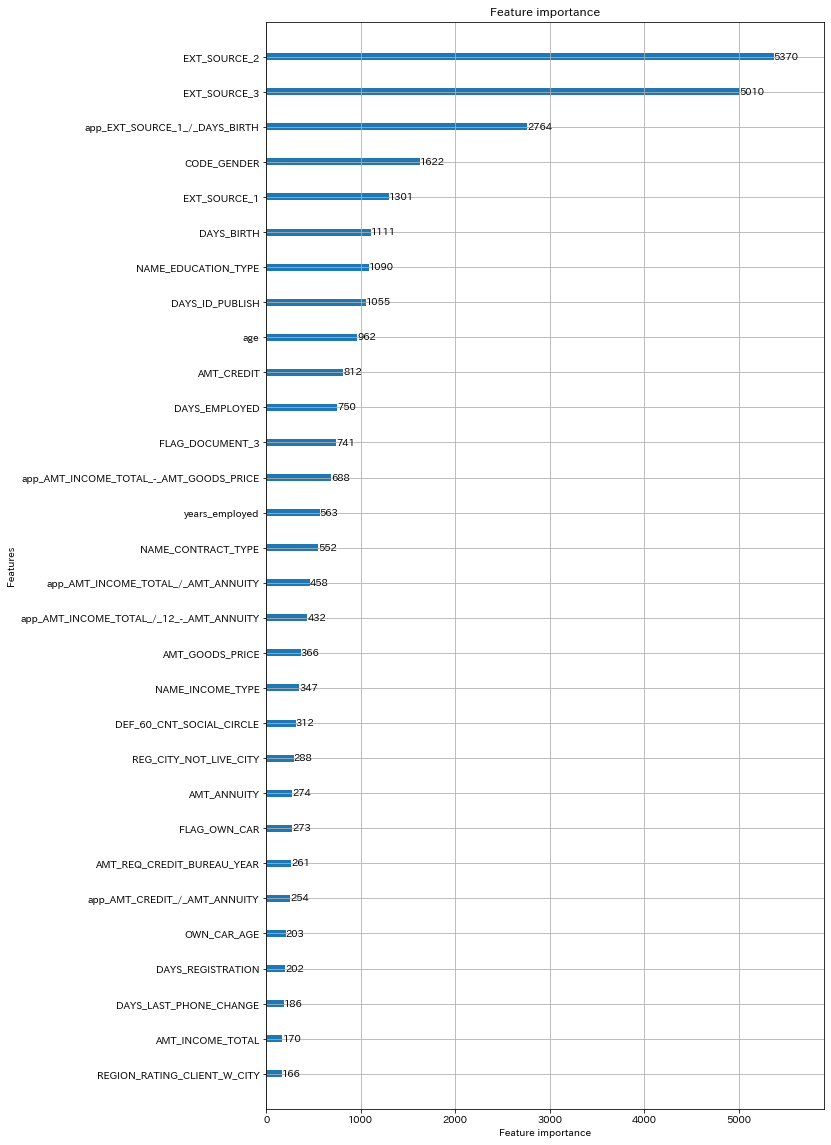

In [372]:
lgb.plot_importance(model, max_num_features=30, figsize=(10, 20))

In [406]:
folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

prediction = np.zeros(X_test.shape[0])
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
        train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]
        train_x, train_y = sampler.fit_resample(train_x, train_y)
        clf = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.1, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = 1000, early_stopping_rounds = 50)
        prediction += clf.predict(X_test)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	training's auc: 0.821572	training's binary_logloss: 0.529363	valid_1's auc: 0.75281	valid_1's binary_logloss: 0.586404
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.813067	training's binary_logloss: 0.537537	valid_1's auc: 0.756636	valid_1's binary_logloss: 0.592095
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	training's auc: 0.825856	training's binary_logloss: 0.524325	valid_1's auc: 0.753916	valid_1's binary_logloss: 0.588959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	training's auc: 0.8417	training's binary_logloss: 0.508281	valid_1's auc: 0.750598	valid_1's binary_logloss: 0.58993


In [409]:
sub = test[['SK_ID_CURR']].copy()
sub['TARGET'] = prediction / 10
sub.to_csv('sub.csv', index= False)

In [410]:
sub['TARGET']

0        0.0
1        0.2
2        0.0
3        0.0
4        0.2
        ... 
48739    0.0
48740    0.2
48741    0.0
48742    0.0
48743    0.3
Name: TARGET, Length: 48744, dtype: float64

In [58]:
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_indexes = []
    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=6785)
    
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x, train_y)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        tr_x, tr_y = sampler.fit_resample(tr_x, tr_y)
        
        model.fit(tr_x, tr_y, 
                  eval_set= [(tr_x, tr_y), (va_x, va_y)],
                  eval_metric='auc',
                  verbose=200, 
                  early_stopping_rounds=20)
        
        
        tr_pred = model.predict(tr_x)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict_proba(test_x)
        preds_test.append(pred_test)
        va_indexes.append(va_idx)
        print('  score Train : {:.6f}' .format(np.sqrt(roc_auc_score(tr_y, tr_pred))), 
              '  score Valid : {:.6f}' .format(np.sqrt(roc_auc_score(va_y, pred)))) 
        
    # バリデーションデータに対する予測値を連結し、その後元の順番に並べなおす
    va_indexes = np.concatenate(va_indexes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_indexes)
    pred_train = pd.DataFrame(preds[order])
    
    
    # テストデータに対する予測値の平均をとる
    preds_test = pd.DataFrame(np.mean(preds_test, axis=0))
    print('Score : {:.6f}' .format(np.sqrt(roc_auc_score(train_y, pred_train))))
    return pred_train, preds_test, model

In [59]:
import time
from sklearn.metrics import roc_auc_score
ts = time.time()
model = lgb.LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.1,
        num_leaves=34,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=5,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        importance_type='gain')
    
pred_train, preds_test, lgbm = predict_cv(model, X, y, X_test)
time.time() - ts

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[148]	training's auc: 0.819215	training's binary_logloss: 0.528738	valid_1's auc: 0.755195	valid_1's binary_logloss: 0.585686
  score Train : 0.858629   score Valid : 0.829486
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[153]	training's auc: 0.818936	training's binary_logloss: 0.529641	valid_1's auc: 0.756282	valid_1's binary_logloss: 0.584684
  score Train : 0.861050   score Valid : 0.830492
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[178]	training's auc: 0.825731	training's binary_logloss: 0.522172	valid_1's auc: 0.760344	valid_1's binary_logloss: 0.585073
  score Train : 0.862309   score Valid : 0.831267
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[141]	training's auc: 0.813496	training's binary_logloss: 0.535353	valid_1's auc: 0.7620

32.21790146827698

In [64]:
sub = test[['SK_ID_CURR']].copy()
sub['TARGET'] = preds_test.iloc[:, 1]
sub.to_csv('sub.csv', index= False)
sns.distplot(sub['TARGET'])

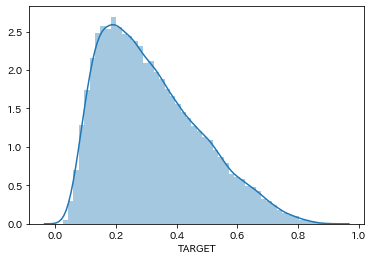

In [66]:
sub['TARGET']

0        0.337572
1        0.435921
2        0.116216
3        0.217221
4        0.551339
           ...   
48739    0.186709
48740    0.395563
48741    0.258577
48742    0.246604
48743    0.530409
Name: TARGET, Length: 48744, dtype: float64